In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng()

In [2]:
def k_cap(input, cap_size):
    output = np.zeros_like(input)
    if len(input.shape) == 1:
        idx = np.argsort(input)[-cap_size:]
        output[idx] = 1
    else:
        idx = np.argsort(input, axis=-1)[:, -cap_size:]
        np.put_along_axis(output, idx, 1, axis=-1)
    return output

In [3]:
n_in = 1000
n_classes = 4
n_neurons = 1000
cap_size = 100
sparsity = 0.1
n_rounds = 5
beta = 1e-1
p_r = 0.9
p_q = 0.1 * cap_size / n_in
mask = (rng.random((n_neurons, n_neurons)) < sparsity) & np.logical_not(np.eye(n_neurons, dtype=bool))
W = np.ones((n_neurons, n_neurons)) * mask
W /= W.sum(axis=0)
mask_a = (rng.random((n_in, n_neurons)) < sparsity)
A = np.ones((n_in, n_neurons)) * mask_a
A /= A.sum(axis=0)

In [4]:
n_samples = n_neurons
means = np.ones((n_classes, n_in)) * p_q
for i in range(n_classes):
    means[i, rng.choice(n_in, size=cap_size, replace=False)] = p_r
inputs = np.stack([rng.random((n_samples, n_in)) < mean[np.newaxis, :] for mean in means])

In [5]:
W = np.ones_like(W) * mask
A = np.ones_like(A) * mask_a
W /= W.sum(axis=0)
A /= A.sum(axis=0)
activations = np.zeros((n_classes, n_rounds, n_neurons))
for i in range(n_classes):
    act_h = np.zeros(n_neurons)
    for j in range(n_rounds):
        input = rng.random(n_in) < means[i]
        act_h_new = k_cap(act_h @ W + input @ A, cap_size)
        activations[i, j] = act_h_new.copy()
        A[(input > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta
        W[(act_h > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta
        act_h = act_h_new
    A /= A.sum(axis=0)
    W /= W.sum(axis=0)

In [6]:
idx = np.full(n_neurons, -1, dtype=int)
act = activations[:, -1].copy()
for i in range(n_classes):
    idx[i*cap_size:(i+1)*cap_size] = act[i].argsort()[-cap_size:][::-1]
    act[:, idx[i*cap_size:(i+1)*cap_size]] = -1
r = np.arange(n_neurons)
r[idx[idx > -1]] = -1
idx[(i+1)*cap_size:] = np.unique(r)[1:]

<IPython.core.display.Javascript object>


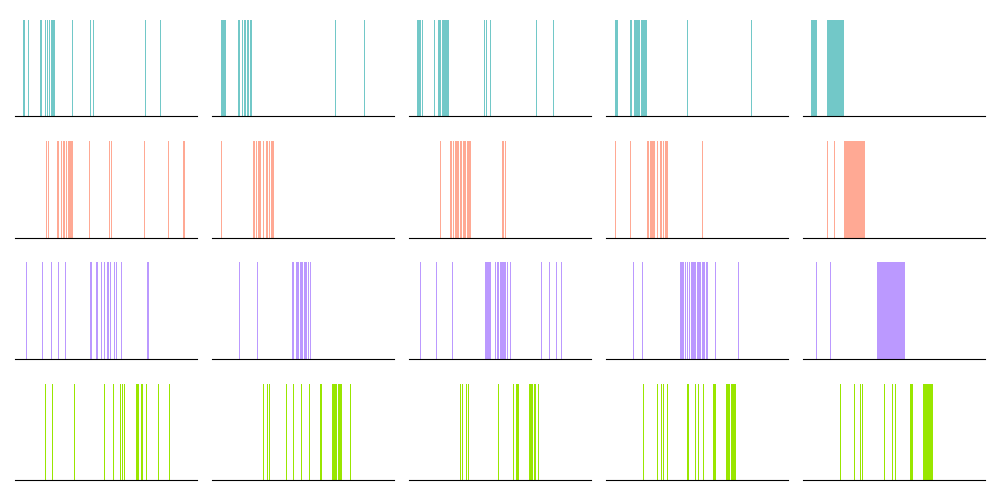

In [7]:
# idx = (activations * np.exp(np.arange(n_classes, 0, -1)).reshape(n_classes, 1, 1)).sum(axis=(0,1)).argsort()
fig, axes = plt.subplots(n_classes, 5, figsize=(10, 5), sharex=True, sharey=True)
colors = ['#72c8c8', '#ffa994', '#bb99ff', '#99e600']
for i in range(5):
    for j in range(n_classes):
        axes[j, i].bar(np.arange(500), activations[j, i, idx[:500]], color=colors[j])
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    for side in ['top', 'right', 'left']:
        ax.spines[side].set_visible(False)
# fig.suptitle('Stimulus Classes')
fig.tight_layout()

In [8]:
outputs = np.zeros((n_classes, n_rounds+1, n_samples, n_neurons))
for i in range(n_rounds):
    for j in range(n_classes):
        outputs[j, i+1] = k_cap(outputs[j, i] @ W + inputs[j] @ A, cap_size)

In [9]:
idx = np.full(n_neurons, -1, dtype=int)
act = outputs[:,-1].sum(axis=1)
for i in range(n_classes):
    idx[i*cap_size:(i+1)*cap_size] = act[i].argsort()[-cap_size:][::-1]
    act[:, idx[i*cap_size:(i+1)*cap_size]] = -1
r = np.arange(n_neurons)
r[idx[idx > -1]] = -1
idx[(i+1)*cap_size:] = np.unique(r)[1:]

<IPython.core.display.Javascript object>


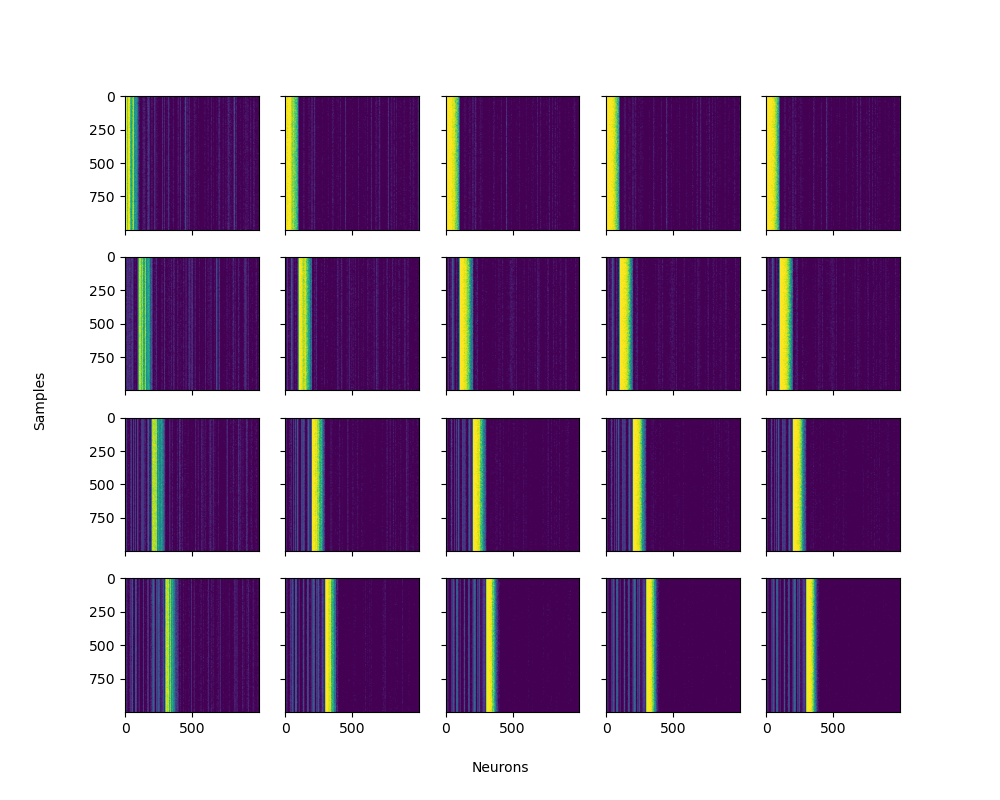

Text(0.04, 0.5, 'Samples')

In [10]:
# idx = (outputs[:, -1] * np.exp(np.arange(n_classes, 0, -1)).reshape(n_classes, 1, 1)).sum(axis=(0,1)).argsort()
fig, axes = plt.subplots(n_classes, n_rounds, figsize=(10, 2 * n_classes), sharex=True, sharey=True)
for ax, output in zip(axes, outputs):
    for i in range(n_rounds):
        ax[i].imshow((output[i+1] > 0)[:, idx])
fig.text(0.5, 0.04, 'Neurons', ha='center', va='center')
fig.text(0.04, 0.5, 'Samples', ha='center', va='center', rotation='vertical')

In [15]:
inp_overlap_mat = np.sum(np.mean(inputs[:, :-1][:, np.newaxis, :] * inputs[:, 1:][np.newaxis, :, :], axis=2), axis=-1)

In [16]:
assm_overlap_mat = np.sum(np.mean(outputs[:, -1, :-1][:, np.newaxis, :] * outputs[:, -1, 1:][np.newaxis, :, :], axis=2), axis=-1)

<IPython.core.display.Javascript object>


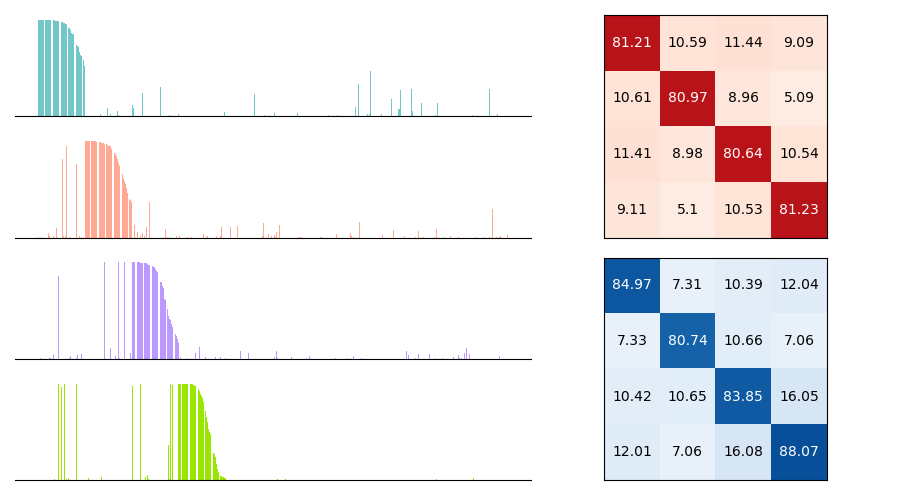

In [17]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(9, 5))
gs = GridSpec(4, 5, figure=fig)
ax0 = plt.subplot(gs[0, :3])
ax0.set_xticks([])
ax0.set_yticks([])
axes = [ax0] + [plt.subplot(gs[i, :3], sharex=ax0, sharey=ax0) for i in range(1, 4)]
colors = ['#72c8c8', '#ffa994', '#bb99ff', '#99e600']
for i in range(4):
    for side in ['top', 'right', 'left']:
        axes[i].spines[side].set_visible(False)
    axes[i].bar(np.arange(n_neurons), outputs[i, -1].mean(axis=0)[idx], color=colors[i])
    
ax0 = plt.subplot(gs[:2, 3:])
ax0.set_xticks([])
ax0.set_yticks([])
ax0.imshow(inp_overlap_mat, vmin=0, vmax=100, cmap='Reds')
for i in range(n_classes):
    for j in range(n_classes):
        ax0.text(j, i, np.round(inp_overlap_mat[i, j], 2), ha='center', va='center', c='w' if i == j else 'k')
ax = plt.subplot(gs[2:, 3:], sharex=ax0, sharey=ax0)
ax.imshow(assm_overlap_mat, vmin=0, vmax=100, cmap='Blues')
for i in range(n_classes):
    for j in range(n_classes):
        ax.text(j, i, np.round(assm_overlap_mat[i, j], 2), ha='center', va='center', c='w' if i == j else 'k')
fig.tight_layout()

In [19]:
n_in = 1000
n_classes = 2
n_neurons = 1000
cap_size = 100
sparsity = 0.1
n_rounds = 5
beta = 1e-1
p_r = 0.9
p_q = 0.1 * cap_size / n_in
mask = (rng.random((n_neurons, n_neurons)) < sparsity) & np.logical_not(np.eye(n_neurons, dtype=bool))
W = np.ones((n_neurons, n_neurons)) * mask
W /= W.sum(axis=0)
mask_a = rng.random((n_in, n_neurons)) < sparsity
A = np.ones((n_in, n_neurons)) * mask_a
A /= A.sum(axis=0)

In [20]:
p_rs = np.linspace(cap_size / n_in, 1.0, 20)
# p_qs = np.linspace(cap_size / n_in, 0.0, 20)
p_q = cap_size / n_in

In [21]:
n_trials = 20
accs = np.zeros((20, n_trials))
for k, p_r in zip(range(20), p_rs):
    for l in range(n_trials):
        n_samples = n_neurons
        means = np.ones((n_classes, n_in)) * p_q
        for i in range(n_classes):
            means[i, rng.choice(n_in, size=cap_size, replace=False)] = p_r
        inputs = np.stack([rng.random((n_samples, n_in)) < mean[np.newaxis, :] for mean in means])
        W = np.ones_like(W) * mask
        A = np.ones_like(A) * mask_a
        W /= W.sum(axis=0)
        A /= A.sum(axis=0)
        activations = np.zeros((n_classes, n_rounds, n_neurons))
        for i in range(n_classes):
            for j in range(n_rounds):
                input = rng.random(n_in) < means[i]
                act_h_new = k_cap(act_h @ W + input @ A, cap_size)
                activations[i, j] = act_h_new.copy()
                A[(input > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta
                W[(act_h > 0)[:, np.newaxis] & (act_h_new > 0)[np.newaxis, :]] *= 1 + beta
                act_h = act_h_new
            A /= A.sum(axis=0)
            W /= W.sum(axis=0)
        outputs = np.zeros((n_classes, n_samples, n_neurons))
        for j in range(n_classes):
            outputs[j] = k_cap(inputs[j] @ A, cap_size)
        c = np.zeros((n_classes, n_neurons))
        for j in range(n_classes):
#             c[j, outputs[j].sum(axis=0).argsort()[-cap_size:]] = 1
            c[j, activations[j, -1] > 0] = 1
        predictions = (outputs @ c.T).argmax(axis=-1)
        accs[k, l] = (predictions == np.arange(n_classes)[:, np.newaxis]).sum() / (n_samples * n_classes)    

<IPython.core.display.Javascript object>


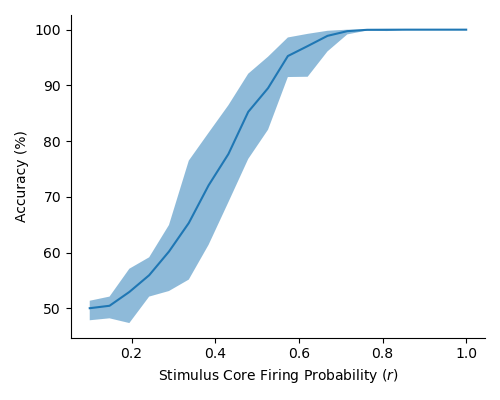

In [23]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.fill_between(p_rs, 100 * accs.min(axis=-1), 100 * accs.max(axis=-1), alpha=0.5)
ax.plot(p_rs, 100 * accs.mean(axis=-1))
ax.set_xlabel(r'Stimulus Core Firing Probability ($r$)')
ax.set_ylabel('Accuracy (%)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()